# Desarrollo 2

## Integrantes

### Santiago Caro Zapata  C.C 1035440607
### Juan Pablo Rojas Marín C.C 1036651490 

### Se importan las librerías necesarias de numpy, scipy y pandas, para trabajar con los archivos de señal. La función firws diseña las ventanas para los filtros lineales FIR.

In [0]:
import numpy as np
import scipy.io as sio
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd

def fkernel(m, f, w):
    m = np.arange(-m/2, (m/2)+1)
    b = np.zeros((m.shape[0]))
    b[m==0] = 2*np.pi*f # No division by zero
    b[m!=0] = np.sin(2*np.pi*f*m[m!=0]) / m[m!=0] # Sinc
    b = b * w # Windowing
    b = b / np.sum(b) # Normalization to unity gain at DC
    return b

def firws(m, f , w , t = None):
    """
    Designs windowed sinc type I linear phase FIR filter.
    Parameters:        
        m: filter order.
        f: cutoff frequency/ies (-6 dB;pi rad / sample).
        w: vector of length m + 1 defining window. 
        t: 'high' for highpass, 'stop' for bandstop filter. {default low-/bandpass}
    Returns:
        b: numpy.ndarray
            filter coefficients 
    """
    f = np.squeeze(f)
    f = f / 2; 
    w = np.squeeze(w)
    if (f.ndim == 0): #low pass
        b = fkernel(m, f, w)
    else:
        b = fkernel(m, f[0], w) #band
    
    if (f.ndim == 0) and (t == 'high'):
        b = fspecinv(b)
    elif (f.size == 2):
        b = b + fspecinv(fkernel(m, f[1], w)) #reject
        if t == None or (t != 'stop'):
            b = fspecinv(b) #bandpass        
    return b

## Spectral inversion
def fspecinv(b):
    b = -b
    b[int((b.shape[0]-1)/2)] = b[int((b.shape[0]-1)/2)]+1
    return b

### La siguiente función permite realizar las gráficas para la respuesta al impulso de un filtro, analizada en el dominio de la frecuencia.

In [0]:
def mfreqz(b,a,order,nyq_rate = 1):
    
    """
    Plot the impulse response of the filter in the frequency domain

    Parameters:
        
        b: numerator values of the transfer function (coefficients of the filter)
        a: denominator values of the transfer function (coefficients of the filter)
        
        order: order of the filter 
                
        nyq_rate = nyquist frequency
    """
    
    w,h = signal.freqz(b,a);
    h_dB = 20 * np.log10 (abs(h));
    
    plt.figure();
    plt.subplot(311);
    plt.plot((w/max(w))*nyq_rate,abs(h));
    plt.ylabel('Magnitude');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Frequency response. Order: ' + str(order));
    [xmin, xmax, ymin, ymax] = plt.axis();
    plt.grid(True);
    
    plt.subplot(312);
    plt.plot((w/max(w))*nyq_rate,h_dB);
    plt.ylabel('Magnitude (db)');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Frequency response. Order: ' + str(order));
    plt.grid(True)
    plt.grid(True)
    
    
    plt.subplot(313);
    h_Phase = np.unwrap(np.arctan2(np.imag(h),np.real(h)));
    plt.plot((w/max(w))*nyq_rate,h_Phase);
    plt.ylabel('Phase (radians)');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Phase response. Order: ' + str(order));
    plt.subplots_adjust(hspace=0.5);
    plt.grid(True)
    plt.show()

### La siguiente función permite diseñar los filtros basados en los siguientes parámetros: periodo de muestreo, frecuencia de corte baja, frecuencia de corte alta.

In [0]:
def filter_design(srate, locutoff = 0, hicutoff = 0, revfilt = 0):
    #Constants
    TRANSWIDTHRATIO = 0.25;
    fNyquist = srate/2;  
    
    #The prototipical filter is the low-pass, we design a low pass and transform it
    if hicutoff == 0: #Convert highpass to inverted lowpass
        hicutoff = locutoff
        locutoff = 0
        revfilt = 1 #invert the logic for low-pass to high-pass and for
                    #band-pass to notch
    if locutoff > 0 and hicutoff > 0:
        edgeArray = np.array([locutoff , hicutoff])
    else:
        edgeArray = np.array([hicutoff]);
    
    #Not negative frequencies and not frequencies above Nyquist
    if np.any(edgeArray<0) or np.any(edgeArray >= fNyquist):
        print('Cutoff frequency out of range')
        return False  
    
    # Max stop-band width
    maxBWArray = edgeArray.copy() # Band-/highpass
    if revfilt == 0: # Band-/lowpass
        maxBWArray[-1] = fNyquist - edgeArray[-1];
    elif len(edgeArray) == 2: # Bandstop
        maxBWArray = np.diff(edgeArray) / 2;
    maxDf = np.min(maxBWArray);
    
    # Default filter order heuristic
    if revfilt == 1: # Highpass and bandstop
        df = np.min([np.max([maxDf * TRANSWIDTHRATIO, 2]) , maxDf]);
    else: # Lowpass and bandpass
        df = np.min([np.max([edgeArray[0] * TRANSWIDTHRATIO, 2]) , maxDf]);
    
    print(df)
    
    filtorder = 3.3 / (df / srate); # Hamming window
    filtorder = np.ceil(filtorder / 2) * 2; # Filter order must be even.
    
    # Passband edge to cutoff (transition band center; -6 dB)
    dfArray = [[df, [-df, df]] , [-df, [df, -df]]];
    cutoffArray = edgeArray + np.array(dfArray[revfilt][len(edgeArray) - 1]) / 2;
    print('pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): '+str(cutoffArray)+' Hz\n');
    # Window
    winArray = signal.hamming(int(filtorder) + 1);
    # Filter coefficients
    if revfilt == 1:
        filterTypeArray = ['high', 'stop'];
        b = firws(filtorder, cutoffArray / fNyquist, winArray, filterTypeArray[len(edgeArray) - 1]);
    else:
        b = firws(filtorder, cutoffArray / fNyquist, winArray);

    return filtorder, b;    



### Con la función matrices archivos realizamos la lectura de datos de los archivos de señales, y eliminamos caracteres no deseados para que puedan ser leídos correctamente. La función umbral utiliza los parametros de la señal filtrada y la segmenta por epocas para luego descartar las que son atípicas.

In [0]:
def matrices_archivos(file,n):
    EEG_C= np.loadtxt(file, delimiter=',',skiprows=6, usecols=(n))
    return EEG_C
def umbral(senal,epoca,fs=250,umb=45):
    mod=len(senal)%(epoca*fs)
    N=(len(senal)-mod)/(epoca*fs)
    signalSplit=np.split(senal[:len(senal)-mod],N)
    r=senal[len(senal)-mod:]
    signalSplit=signalSplit+[r]
    
#    for segmento in range(10):
#        time=np.arange(0, len(signalSplit[segmento])/fs,1/fs)
#        plt.plot(time,signalSplit[segmento])
#        plt.show()
    
    for segmento in signalSplit:
        if np.max(segmento)>umb or np.min(segmento)<-umb:
            for j in range(len(segmento)):
                segmento[j]=0
    signalComplete=np.concatenate(signalSplit)
      
    return signalComplete

### A continuación se diseñan los filtros bajo la función filter design, donde creamos un pasa altas de 5hz y un pasabajas de 50hz para posteriormente ser aplicados a las señales importadas. Por último se aplicó la función umbral para que eliminara los picos atípicos de cada época. 

In [0]:
EEG_C=matrices_archivos("P1_RAWEEG_2018-11-15_Electrobisturí1_3min.txt",2)
fs=250
tiempo=np.arange(0, len(EEG_C)/250,1/250)

12.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [56.25] Hz

2.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [2.] Hz



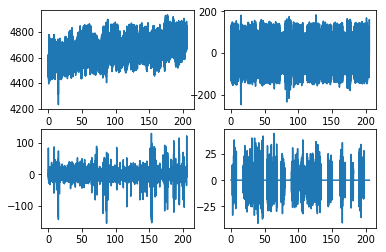

In [0]:
##design
order, lowpass = filter_design(fs, locutoff = 0, hicutoff = 50, revfilt = 0);
##plot
#mfreqz(lowpass,1,order, fs/2);
#
order, highpass = filter_design(fs, locutoff = 3, hicutoff = 0, revfilt = 1);
##plot
#mfreqz(highpass,1,order, fs/2);

senal_filtrada_pasaaltas = signal.filtfilt(highpass, 1, EEG_C);
senal_filtrada_pasabajas = signal.filtfilt(lowpass, 1, senal_filtrada_pasaaltas);
#senal_filtrada_pasabajas = signal.filtfilt(notch, 1, senal_filtrada_pasabajas);
#senal_filtrada=np.fft.fft(senal_filtrada_pasabajas)
#plt.plot(tiempo,senal_filtrada_pasabajas)

#plt.plot(f,pot)
#plt.xlim(0,10)
#plt.plot(tiempo[0:10*fs],senal_filtrada_pasabajas[0:10*fs])
#plt.show()


plt.subplot(2,2,1)
plt.plot(tiempo, EEG_C)
plt.subplot(2,2,2)
plt.plot(tiempo,senal_filtrada_pasaaltas)
plt.subplot(2,2,3)
plt.plot(tiempo,senal_filtrada_pasabajas)
plt.subplot(2,2,4)
EEGconUmbral=umbral(senal_filtrada_pasabajas ,2)
plt.plot(tiempo,EEGconUmbral)
plt.show()


### A continuación se realiza el mismo procedimiento que el paso anterior, pero en este caso variando los parametros de los filtros para ver el comportamiento de la señal. En este caso variamos el parámetro del filtro pasa altas de tal manera que deje pasar las frecuencias despues de 0.5Hz, para así poder tener en cuenta las ondas delta. Además diminuiremos el periodo de la epoca a 1, para así tomar de a 1 segundo de la señal.

12.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [56.25] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



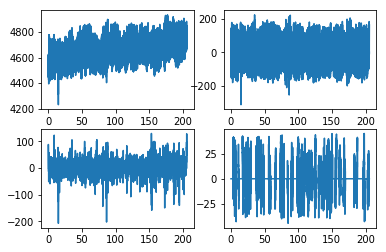

In [0]:
order, lowpass = filter_design(fs, locutoff = 0, hicutoff = 50, revfilt = 0);
order, highpass = filter_design(fs, locutoff = 0.5, hicutoff = 0, revfilt = 1);

senal_filtrada_pasaaltas = signal.filtfilt(highpass, 1, EEG_C);
senal_filtrada_pasabajas = signal.filtfilt(lowpass, 1, senal_filtrada_pasaaltas);

plt.subplot(2,2,1)
plt.plot(tiempo, EEG_C)
plt.subplot(2,2,2)
plt.plot(tiempo,senal_filtrada_pasaaltas)
plt.subplot(2,2,3)
plt.plot(tiempo,senal_filtrada_pasabajas)
plt.subplot(2,2,4)
EEGconUmbral=umbral(senal_filtrada_pasabajas ,1)
plt.plot(tiempo,EEGconUmbral)
plt.show()

#### Con los resultados anteriores, tenemos que, aunque las dos configuraciones previas de los filtros sean muy eficientes, la última permite tener en cuenta un rango de frecuencias más amplio, para así poder analizar todas las componentes de las ondas cerebrales gracias a que aunque disminiumos la frecuencia del filtro pasa altas, también aumentamos el numero de epocas, permitiendo así eliminar menos segmentos establecidos por el umbral, por lo que la señal final se verá menos afectada.

### Seguidamente se realiza el mismo procedimiento para la segunda señal, correspondiente al electro bisturí en 2 min, asi que con esta se utilizará la configuración de filtros que mejores resultados arrojo en la señal anterior 

In [0]:
EEG_C=matrices_archivos("P1_RAWEEG_2018-11-15_Electrobisturí2_2min.txt",2)
fs=250
tiempo=np.arange(0, len(EEG_C)/250,1/250)

12.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [56.25] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



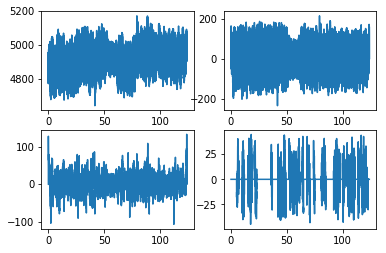

In [0]:
order, lowpass = filter_design(fs, locutoff = 0, hicutoff = 50, revfilt = 0);
order, highpass = filter_design(fs, locutoff = 0.5, hicutoff = 0, revfilt = 1);

senal_filtrada_pasaaltas = signal.filtfilt(highpass, 1, EEG_C);
senal_filtrada_pasabajas = signal.filtfilt(lowpass, 1, senal_filtrada_pasaaltas);

plt.subplot(2,2,1)
plt.plot(tiempo, EEG_C)
plt.subplot(2,2,2)
plt.plot(tiempo,senal_filtrada_pasaaltas)
plt.subplot(2,2,3)
plt.plot(tiempo,senal_filtrada_pasabajas)
plt.subplot(2,2,4)
EEGconUmbral=umbral(senal_filtrada_pasabajas ,1)
plt.plot(tiempo,EEGconUmbral)
plt.show()

### Como se puede ver en las anteriores graficas del punto anterior, con el filtro por umbral se eliminaron gran cantidad de segmentos, por ende para el siguiente filtro se uso cambio el filtro pasa altas por uno con frecuencia de corte igual a 1 Hz.

12.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [56.25] Hz

1.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.5] Hz



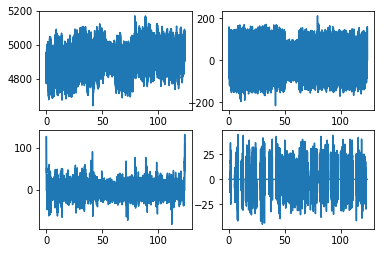

In [0]:

order, lowpass = filter_design(fs, locutoff = 0, hicutoff = 50, revfilt = 0);
order, highpass = filter_design(fs, locutoff = 1, hicutoff = 0, revfilt = 1);

senal_filtrada_pasaaltas = signal.filtfilt(highpass, 1, EEG_C);
senal_filtrada_pasabajas = signal.filtfilt(lowpass, 1, senal_filtrada_pasaaltas);

plt.subplot(2,2,1)
plt.plot(tiempo, EEG_C)
plt.subplot(2,2,2)
plt.plot(tiempo,senal_filtrada_pasaaltas)
plt.subplot(2,2,3)
plt.plot(tiempo,senal_filtrada_pasabajas)
plt.subplot(2,2,4)
EEGconUmbral=umbral(senal_filtrada_pasabajas ,1)
plt.plot(tiempo,EEGconUmbral)
plt.show()


#### De las dos configuraciones utilizadas la que menos epocas elimino fue el segundo, aunque se tuvo que aumentar la frecuencia de corte del filtro pasa altas, por lo cual no se tiene encuenta algunas de las ondas tipo delta

### Por ultimo, se usaron otras dos configuraciones de filtros para la tercera señal utilizada(Ojos cerrados durante 2 min)

In [0]:
EEG_C=matrices_archivos("P1_RAWEEG_2018-11-15_OjosCerrados_2min.txt",2)
fs=250
tiempo=np.arange(0, len(EEG_C)/250,1/250)

12.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [56.25] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



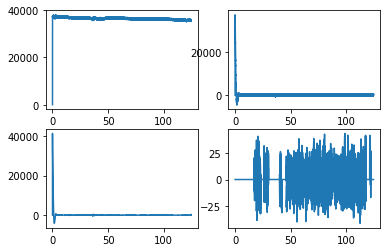

In [0]:
order, lowpass = filter_design(fs, locutoff = 0, hicutoff = 50, revfilt = 0);
order, highpass = filter_design(fs, locutoff = 0.5, hicutoff = 0, revfilt = 1);

senal_filtrada_pasaaltas = signal.filtfilt(highpass, 1, EEG_C);
senal_filtrada_pasabajas = signal.filtfilt(lowpass, 1, senal_filtrada_pasaaltas);

plt.subplot(2,2,1)
plt.plot(tiempo, EEG_C)
plt.subplot(2,2,2)
plt.plot(tiempo,senal_filtrada_pasaaltas)
plt.subplot(2,2,3)
plt.plot(tiempo,senal_filtrada_pasabajas)
plt.subplot(2,2,4)
EEGconUmbral=umbral(senal_filtrada_pasabajas ,1)
plt.plot(tiempo,EEGconUmbral)
plt.show()

12.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [56.25] Hz

2.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [1.] Hz



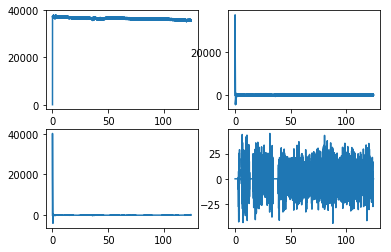

In [0]:
order, lowpass = filter_design(fs, locutoff = 0, hicutoff = 50, revfilt = 0);
order, highpass = filter_design(fs, locutoff = 2, hicutoff = 0, revfilt = 1);

senal_filtrada_pasaaltas = signal.filtfilt(highpass, 1, EEG_C);
senal_filtrada_pasabajas = signal.filtfilt(lowpass, 1, senal_filtrada_pasaaltas);

plt.subplot(2,2,1)
plt.plot(tiempo, EEG_C)
plt.subplot(2,2,2)
plt.plot(tiempo,senal_filtrada_pasaaltas)
plt.subplot(2,2,3)
plt.plot(tiempo,senal_filtrada_pasabajas)
plt.subplot(2,2,4)
EEGconUmbral=umbral(senal_filtrada_pasabajas ,1)
plt.plot(tiempo,EEGconUmbral)
plt.show()

## Segundo Punto

In [0]:
def analisis(senal,fs=250):
  
  tiempo=np.arange(0, len(senal)/fs,1/fs)
  plt.plot(tiempo,senal)
  #plt.plot(tiempo,senal)
  plt.show()
  f,pot=signal.welch(senal,fs,'hanning',fs*2,fs)
  plt.plot(f[:101],pot[:101])
  plt.show()

def filtros(senal,fs=250):
  order, lowpass = filter_design(fs, locutoff = 0, hicutoff = 49, revfilt = 0);
  order, highpass = filter_design(fs, locutoff = 0.5, hicutoff = 0, revfilt = 1);

  senal_filtrada_pasaaltas = signal.filtfilt(highpass, 1, senal);
  senal_filtrada_pasabajas = signal.filtfilt(lowpass, 1, senal_filtrada_pasaaltas);
  EEGfiltrada=umbral(senal_filtrada_pasabajas,1)
  #plt.plot(tiempo,EEGfiltrada)
  #plt.show()
  return EEGfiltrada


12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



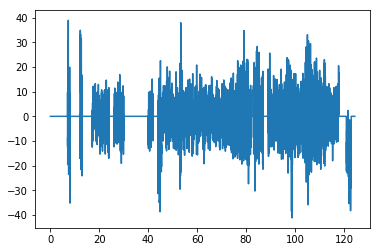

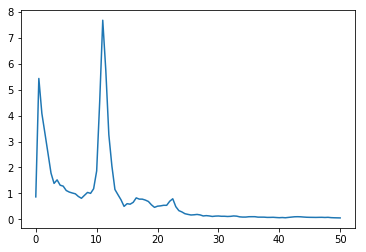

In [0]:
EEG2=matrices_archivos("P1_RAWEEG_2018-11-15_OjosCerrados_2min.txt",2)
EEG3=matrices_archivos("P1_RAWEEG_2018-11-15_OjosCerrados_2min.txt",3)
EEG4=matrices_archivos("P1_RAWEEG_2018-11-15_OjosCerrados_2min.txt",4)
fs=250
#analisis(EEG2)

EEGfiltrada2=filtros(EEG2)
EEGfiltrada3=filtros(EEG3)
#analisis(EEGfiltrada2)
#analisis(EEGfiltrada3)

senalbipolar32=EEGfiltrada3-EEGfiltrada2
analisis(senalbipolar32)


  

### Con la información dada en la ultima gráfica que refleja el espectro del montaje bipolar uno, observamos una disminución en la amplitud de las ondas alfa y un aumento en la amplitud de las ondas beta, resultando como era de esperarse ya que en este momento el paciente se encuentra durante la etapa de inducción. Luego vemos a continuación, que a medida que a medida que aumenta la concentración de anestesico para perder el estado de conciencia, aumenta la banda alfa y disminuye la banda beta, como resulta en el espectro del montaje bipolar dos.

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



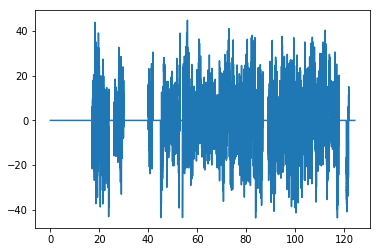

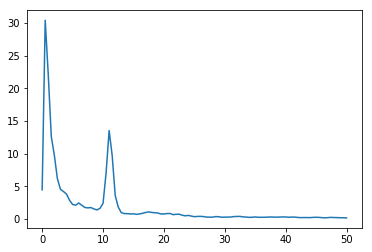

In [0]:
EEGfiltrada4=filtros(EEG4)


senalbipolar42=EEGfiltrada4-EEGfiltrada2
analisis(senalbipolar42)

### A analizar el espectro de los montajes bipolares para la señal al inicio de la cirugía, a continuación, vemos que se encuentra un comportamiento similar al esperado, ya que vemos que continúa disminuyendo la banda beta y aumentando cada vez más la banda alfa, para que sea este el punto optimo para comenzar la intervensión.

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



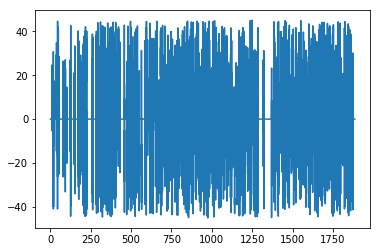

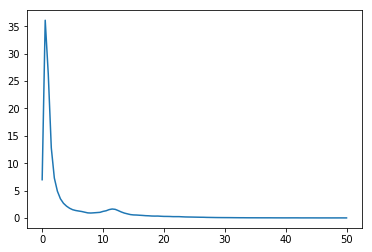

In [0]:
EEG2=matrices_archivos("P1_RAWEEG_2018-11-15_InicioCirugía_31min.txt",2)
EEG3=matrices_archivos("P1_RAWEEG_2018-11-15_InicioCirugía_31min.txt",3)
EEG4=matrices_archivos("P1_RAWEEG_2018-11-15_InicioCirugía_31min.txt",4)
fs=250
#analisis(EEG2)

EEGfiltrada2=filtros(EEG2)
EEGfiltrada3=filtros(EEG3)
#analisis(EEGfiltrada2)
#analisis(EEGfiltrada3)

senalbipolar32=EEGfiltrada3-EEGfiltrada2
analisis(senalbipolar32)

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



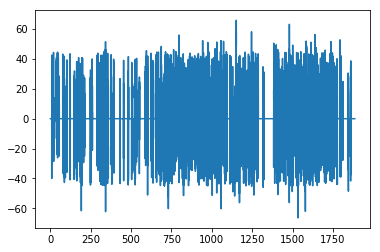

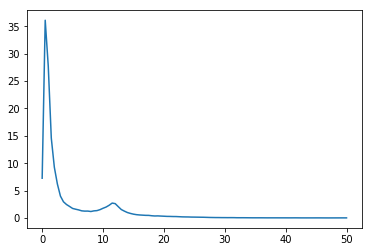

In [0]:
EEGfiltrada4=filtros(EEG4)


senalbipolar42=EEGfiltrada4-EEGfiltrada2
analisis(senalbipolar42)

### A continuación veremos como se comporta el espectro sobre los montajes bipolares durante la cirugía y al final de la cirugía. Lo más importante a destacar en el espectro esperado es que al final de la cirugía, es decir, cuando el paciente empieza a retomar conciencia, este debe comportarse contrario a cuando el paciente está en la fase de inducción. Según la gráfica del espectro del final de la cirugía, la amplitud de la onda alfa es mayor que la amplitud de la onda beta, contrario a la fase de inducción donde la onda alfa tiene una amplitud menor que la onda beta.

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



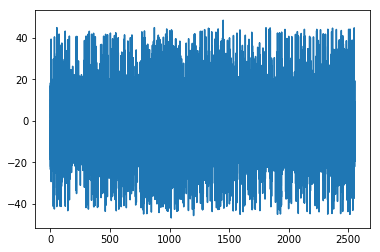

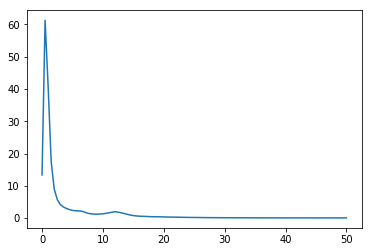

In [0]:
EEG2_1=matrices_archivos("P1_RAWEEG_2018-11-15_DuranteCirugía_42min.txt",2)
EEG3_1=matrices_archivos("P1_RAWEEG_2018-11-15_DuranteCirugía_42min.txt",3)
EEG4_1=matrices_archivos("P1_RAWEEG_2018-11-15_DuranteCirugía_42min.txt",4)
fs=250
#analisis(EEG2)

EEGfiltrada2_1=filtros(EEG2_1)
EEGfiltrada3_1=filtros(EEG3_1)
#analisis(EEGfiltrada2)
#analisis(EEGfiltrada3)

senalbipolar32_1=EEGfiltrada3_1-EEGfiltrada2_1
analisis(senalbipolar32_1)

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



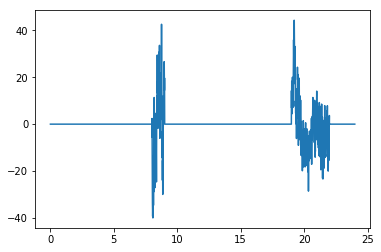

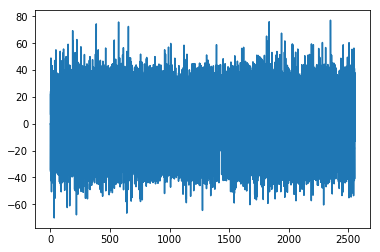

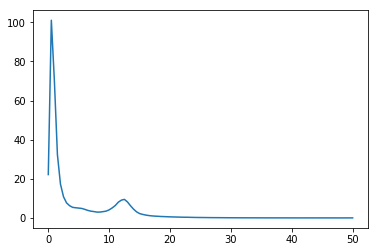

In [0]:
EEGfiltrada4_1=filtros(EEG4_1)


senalbipolar42_1=EEGfiltrada4_1-EEGfiltrada2_1
plt.plot(tiempo[:6000],senalbipolar42[:6000])
plt.show()
analisis(senalbipolar42_1)

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



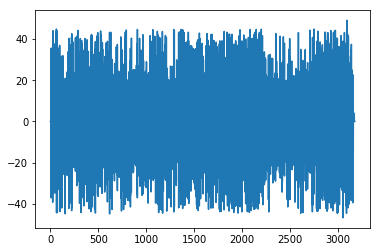

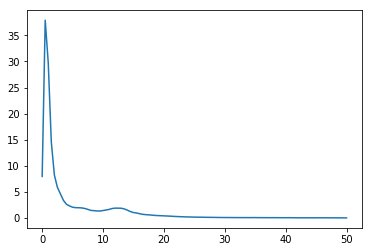

In [0]:
EEG2_1=matrices_archivos("P1_RAWEEG_2018-11-15_FinCirugía_53min.txt",2)
EEG3_1=matrices_archivos("P1_RAWEEG_2018-11-15_FinCirugía_53min.txt",3)
EEG4_1=matrices_archivos("P1_RAWEEG_2018-11-15_FinCirugía_53min.txt",4)
fs=250
#analisis(EEG2)

EEGfiltrada2_1=filtros(EEG2_1)
EEGfiltrada3_1=filtros(EEG3_1)
#analisis(EEGfiltrada2)
#analisis(EEGfiltrada3)

senalbipolar32_1=EEGfiltrada3_1-EEGfiltrada2_1
analisis(senalbipolar32_1)

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz



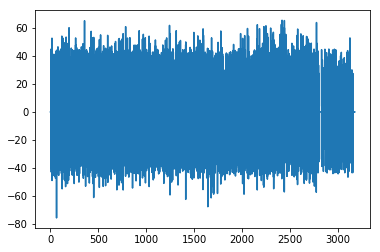

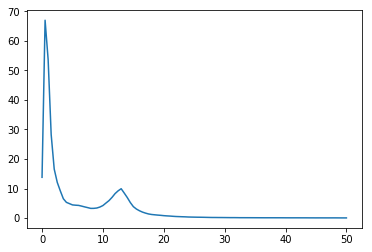

In [0]:
EEGfiltrada4_1=filtros(EEG4_1)


senalbipolar42_1=EEGfiltrada4_1-EEGfiltrada2_1
analisis(senalbipolar42_1)

### Al final de la cirugía vemos que las ondas con mayor potencia relativa serán las ondas alfa y beta respectivamente, donde vemos que como era de esperarse la onda alfa tiene una mayor energía relativa al tener mayor amplitud y la onda beta disminuye considerablemente su energía relativa debido a que tiene menor amplitud.

In [0]:
def potencia_relativa(senal):
  num_puntos_por_segundo=1000
  
  nperseg=2048
  noverlap=int(nperseg/2)
  f,Pxx=signal.welch(senal,num_puntos_por_segundo,'hanning',nperseg,noverlap)
  #extraemos la potencia de cada banda
  delta=np.sum(Pxx[f <=4])
  theta=np.sum(Pxx[(f>4)&(f<=8)])
  alfa=np.sum(Pxx[(f>8)&(f<=13)])
  beta=np.sum(Pxx[(f>13)&(f<=30)])
  #extraemos la potencia total
  total=np.sum(Pxx[f<=30])
  
  #se extrae la potencia relativa
  delta_relativo=delta/total
  theta_relativo=theta/total
  alfa_relativo=alfa/total
  beta_relativo=beta/total
  
  # se convierte la lista de python a un array de numpy
  resultado=np.asarray([delta_relativo,theta_relativo,alfa_relativo,beta_relativo])
  return resultado

# Cambios de potencia relativa para el canal 2 de la señal referente al fin de la cirugía
resultado=potencia_relativa(EEGfiltrada2_1)
print(resultado)

[0.52873657 0.20439087 0.10686824 0.16000432]


### Vemos que el mismo comportamiento ocurre en la señal filtrada durante la cirugía, pero con una leve diferencia en los valores debido a que en este caso la componente alta tenía mayor amplitud y la componente beta tenía menor amplitud.

In [0]:
EEG2_2=matrices_archivos("P1_RAWEEG_2018-11-15_DuranteCirugía_42min.txt",2)
fs=250
#analisis(EEG2)

EEGfiltrada2_2=filtros(EEG2_2)

#analisis(EEGfiltrada2)
#analisis(EEGfiltrada3)

resultado=potencia_relativa(EEGfiltrada2_2)
print(resultado)

12.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [55.125] Hz

0.5
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [0.25] Hz

[0.63803686 0.16755969 0.0740675  0.12033596]


### Conclusiones

* ### La reacción a la anestesia durante el proceso de cirugía de un paciente puede ser debidamente controlada y monitoreada analizando los espectros de frecuencia de las diferentes bandas que componen la señal neurológica, y gracias a esto se pueden también detectar reacciones adversas que el sujeto esté teniendo por la asimilación de la anestesia, evitando así posibles complicaciones.

* ### Con la ayuda de un filtro pasa altas, un pasabajas y un algoritmo de eliminación de etapas afectadas por ruido por artefactos se puede obtener una señal neurológica que pueda ser analizada. En cuanto al primer filtro, tenemos qu este elimina algun nivel DC que posea la señal, en cuanto al segundo, nos ayuda a eliminar generalmente ruido electromagnético de 60Hz que es muy común en la obtención de este tipo de señales, y finalmente el eliminar etapas que sobrepasan un determinado umbral me permite eliminar de la señal componentes atípicos que podrían generar interferencias al momento de analizar la señal.

* ### Se debe tener mucha precaución a la hora de realizar el filtrado de las señales, debido a que hacer filtros con frecuencias de corte no opitmas, apesar de elimininar las frecuencias indeseadas, tambien se pierden frecuencias que son necesarias para el analisis de la señal.